# Imports

In [653]:
import os
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns

rd = np.random.RandomState(23523)

# Lista 2

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Disciplina: Tópicos Especiais em Aprendizagem de Máquina / Tópicos Especiais em Lógica II

# Assignment 1 - Bayesian Logistic Regression

In [654]:
# READING DATA
data = np.genfromtxt('../data/logistic_regression_data.csv', delimiter=',')
print('Shape:', data.shape)
data[:5,:]

Shape: (100, 3)


array([[ 1.58147244, -1.44901999,  0.        ],
       [ 2.03272549, -1.10887429,  0.        ],
       [ 0.87462429, -0.74638988,  0.        ],
       [-1.69579455, -0.5465131 ,  1.        ],
       [ 1.59245283, -0.77206788,  0.        ]])

In [655]:
class BayesianLogisticRegression:

    def __init__(self,  m_0, S_0):       
        self.m_0 = m_0.reshape(-1, 1)
        self.S_0 = S_0
        self.irls_loss_hist = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def cross_entropy_loss(self, y, y_pred_proba):
        cost_1 = y.T @ np.log(y_pred_proba)
        cost_0 = (1-y).T @ np.log(1-y_pred_proba)
        j = -(1/len(y)) * (cost_1 + cost_0)
        return j.ravel()[0]

    def irls(self, X, y, n_iterations):
        # Set initial values
        self.w_hat = rd.uniform(0, 1, size=(X.shape[1], 1))
        self.irls_loss_hist = []

        for _ in range(n_iterations):
            R = self.sigmoid(self.w_hat.T @ X.T).T @ (1 - self.sigmoid(self.w_hat.T @ X.T))
            R = R * np.identity(R.shape[0])
            S_0_inv = np.linalg.pinv(self.S_0)
            self.H = X.T @ R @ X + S_0_inv
            self.H_inv = np.linalg.pinv(self.H)
            sig_X_dot_w = self.sigmoid(X @ self.w_hat)
            self.w_hat = self.w_hat + self.H_inv @ (X.T @ (y - sig_X_dot_w)) - S_0_inv @ (self.w_hat - self.m_0)

            y_pred = self.non_bayesian_predict(X)
            self.irls_loss_hist.append(self.cross_entropy_loss(y, y_pred))     

    def sample_posteriori(self):
        return multivariate_normal(self.w_hat.ravel(), self.H_inv).rvs()

    def predict(self, X):
        # PROBIT APROXIMATION
        mu_a = X @ self.w_hat
        sigma_a_square = np.diag(X @ np.linalg.pinv(self.H) @ X.T).reshape(-1, 1)

        return self.sigmoid((1 + np.sqrt(np.pi*sigma_a_square/8))*mu_a)

In [681]:
# SPLITING X AND Y
X = data[:,:-1]
X = np.hstack([np.ones(shape=(X.shape[0], 1)), X])
y = data[:,[-1]]

# SETTING PRIORI PARAMETERS
m_0 = np.array([[1, 1, -1]])
S_0 = np.array([
    [1, 0, 0],
    [0, 1, -1],
    [0, -1, 1]
])
S_0 = S_0.T @ S_0

blr = BayesianLogisticRegression(m_0, S_0)

N = 100
indexes = rd.randint(0, 100, N)
X, y = X[indexes], y[indexes]

blr.irls(X, y, n_iterations=50)

(-2.0, 1.0)

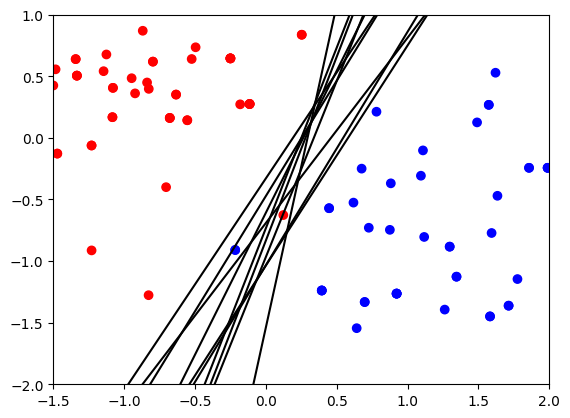

In [685]:
# DECISION BOUNDARIES
for i in range(10):

    intercept, w1, w2 = blr.sample_posteriori()
    # Calculate the intercept and gradient of the decision boundary.
    c = -intercept/w2
    m = -w1/w2

    # Plot the data and the classification with the decision boundary.
    xmin, xmax = -1.5, 2
    ymin, ymax = -2, 1
    xd = np.array([xmin, xmax])
    yd = m*xd + c
    plt.plot(xd, yd, 'k', )

plt.scatter(X[:, 1], X[:, 2], c=np.where(y, 'red', 'blue').ravel())
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

Text(0, 0.5, 'Loss')

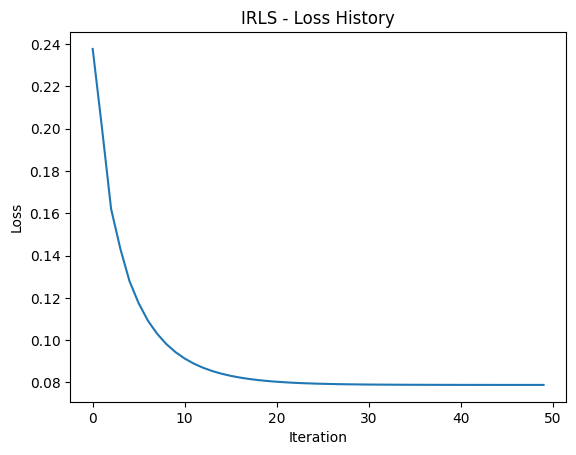

In [686]:
# IRLS LOSS CURVE
plt.plot(blr.irls_loss_hist)
plt.title('IRLS - Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Predictive Distribution with Probit Approximation')

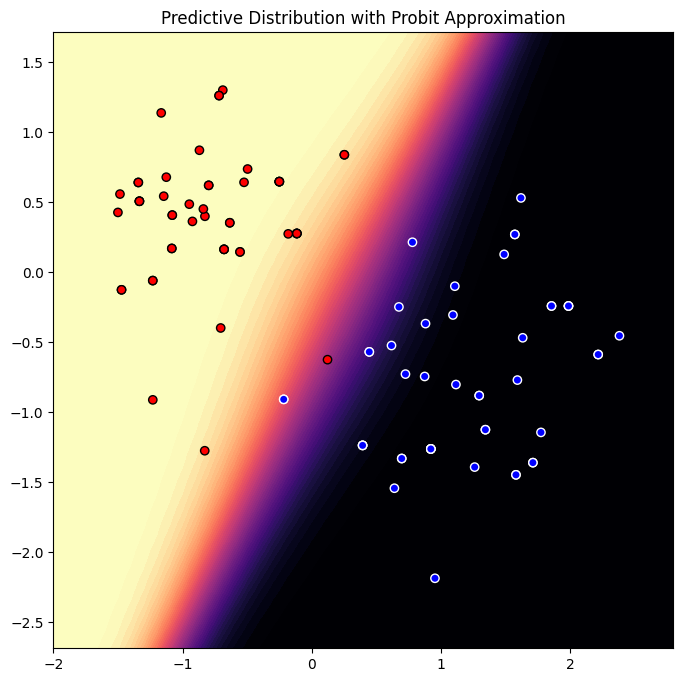

In [687]:
x_1, x_2 = X[:, 1], X[:, 2]
X_1, X_2 = np.meshgrid(
    np.arange(x_1.min()-0.5, x_1.max()+0.5, 0.1),
    np.arange(x_2.min()-0.5, x_2.max()+0.5, 0.1),
)

X_to_pred = np.hstack([
    np.ones_like(X_1).reshape(-1, 1), 
    X_1.reshape(-1, 1), 
    X_2.reshape(-1, 1)]
)
Z = blr.predict(X_to_pred)
Z = Z.reshape(X_1.shape)

fig1, ax2 = plt.subplots(figsize=(8, 8))
CS = ax2.contourf(X_1, X_2, Z, levels=50, cmap='magma', extend ='both',
                  alpha = 1)
plt.scatter(
    X[:, 1], X[:, 2], 
    c=np.where(y, 'red', 'blue').ravel(), 
    edgecolor=np.where(y, 'black', 'white').ravel()
)

plt.title('Predictive Distribution with Probit Approximation')

# Assignment 2 - Bayesian Naive Bayes

In [688]:
# READING DATA
df = pd.read_csv('../data/votesDataset.csv')
print('Shape:', df.shape)

X = df.iloc[:, 1:]
y = df.iloc[:, [0]].replace({'republican': 0, 'democrat': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64852)
df.head()

Shape: (435, 17)


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,republican,0,1,0,1,1,1,0,0,0,1,0,1,1,0,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,0,0,1
2,democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0
3,democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1
4,democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,0,1,1


In [689]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

display(X_train[:5, :])
display(y_train[:5, :])

array([[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]], dtype=int64)

array([[1],
       [0],
       [1],
       [1],
       [1]], dtype=int64)

In [690]:
class BayesianNaiveBayes():
    def __init__(self):        
        pass

    def set_priori_params(
        self,
        dirichlet_alpha,
        beta_a,
        beta_b
    ):
        self.dirichlet_alpha = dirichlet_alpha
        self.beta_a = beta_a
        self.beta_b = beta_b

    def fit(self, X, y):

        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        classes = np.unique(y)
        self.class_to_idx_dict = {classes[i]: i for i in range(len(classes))}

        n_features = X.shape[1]

        self.pi = np.zeros((len(classes), 1)) # n_classes x 1
        self.theta = np.zeros((len(classes), n_features)) # n_classes x n_features
        

        for label in classes:
            c = self.class_to_idx_dict[label]
            X_class = X[np.where(y==label)[0], :]
            y_class = y[np.where(y==label)[0], :]


            # SETTING PI
            N_c = y_class.shape[0]
            N = y.shape[0]
            dir_alpha = self.dirichlet_alpha[c]
            dir_sum_alphas = np.sum(self.dirichlet_alpha)

            self.pi[c] = (N_c + dir_alpha) / (N + dir_sum_alphas)


            # SETTING THETA
            N_dc = np.sum(X_class, axis=0)
            
            self.theta[c] = (N_dc + self.beta_b) / (N_c + self.beta_a + self.beta_b)


    def predict(self, X):

        idx_to_class = {v: k for k, v in self.class_to_idx_dict.items()}
        prob_classes = np.zeros((X.shape[0], len(idx_to_class)))

        for i, label in enumerate(idx_to_class.values()):

            c = self.class_to_idx_dict[label]
            pi = self.pi[c]
            theta = self.theta[[c]]
            
            for idx, x in enumerate(X):
                first_term = np.log(pi)
                second_term = np.sum(np.log(theta, where=x.astype(bool)))
                third_term = np.sum(np.log(1 - theta, where=np.abs(x - 1).astype(bool)))
                
                pred = first_term + second_term + third_term
                prob_classes[idx, i] = pred
                

        preds = []

        for i in range(prob_classes.shape[0]):
            argmax = np.argmax(prob_classes[i, :])
            preds.append(idx_to_class[argmax])
            
        return np.array(preds).reshape(-1, 1)

In [691]:
my_bnb = BayesianNaiveBayes()
my_bnb.set_priori_params(
    dirichlet_alpha=[1, 2],
    beta_a=1,
    beta_b=0
)

In [692]:
# FIT
my_bnb.fit(X_train, y_train)

# PREDICTION
y_pred = my_bnb.predict(X_test)
cf = confusion_matrix(y_test, y_pred)
cf

array([[37,  7],
       [11, 76]], dtype=int64)

<AxesSubplot:>

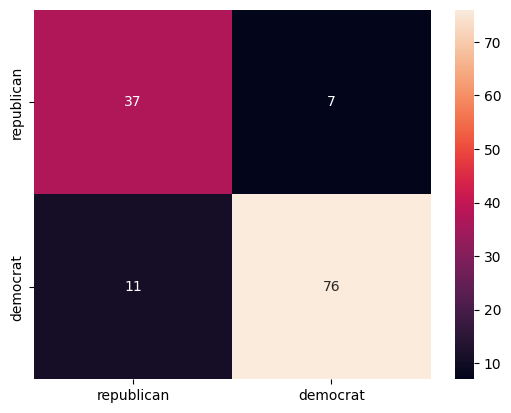

In [693]:
sns.heatmap(
    cf, 
    annot=True, 
    xticklabels=['republican', 'democrat'], 
    yticklabels=['republican', 'democrat']
)